In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier


In [2]:
insurance_train = pd.read_csv('insurance_train.csv')
insurance_test = pd.read_csv('insurance_test.csv')

In [3]:
insurance_train.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Does_Not_Buy
0,Female,21,1,1,< 1 Year,No,699.777,59,1
1,Female,23,1,1,< 1 Year,No,364.819,163,1
2,Male,32,1,0,< 1 Year,Yes,355.004,261,1
3,Female,44,1,0,> 2 Years,Yes,885.586,73,0
4,Female,24,1,1,< 1 Year,No,493.688,124,1


In [4]:
logreg = smf.logit(formula = 'Does_Not_Buy ~ Gender + Age + Driving_License + Previously_Insured +  Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage',
                   data = insurance_train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.417442
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:           Does_Not_Buy   No. Observations:                36083
Model:                          Logit   Df Residuals:                    36073
Method:                           MLE   Df Model:                            9
Date:                Thu, 21 Oct 2021   Pseudo R-squ.:                  0.3222
Time:                        18:25:13   Log-Likelihood:                -15063.
converged:                       True   LL-Null:                       -22223.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.8001      0.314      5.738      0.000       1.18

In [6]:
y_test_log = insurance_test['Does_Not_Buy']

In [7]:
y_prob_log = logreg.predict(insurance_test)
y_prob_log

0        0.998077
1        0.504860
2        0.996145
3        0.536968
4        0.367236
           ...   
12023    0.607896
12024    0.996076
12025    0.602668
12026    0.995893
12027    0.644091
Length: 12028, dtype: float64

In [8]:
y_pred_log = pd.Series([1 if x > 0.417 else 0 for x in y_prob_log], index=y_prob_log.index)
y_pred_log

0        1
1        1
2        1
3        1
4        0
        ..
12023    1
12024    1
12025    1
12026    1
12027    1
Length: 12028, dtype: int64

In [9]:
np.mean(y_pred_log) #this indicates that the majority value is 1, i.e. does not buy

0.8420352510808115

In [10]:
cm_log = confusion_matrix(y_test_log, y_pred_log)
print ("Confusion Matrix : \n", cm_log) 

Confusion Matrix : 
 [[1181 2487]
 [ 719 7641]]


In [44]:
# Accuracy
acc_log = (cm_log.ravel()[0]+cm_log.ravel()[3])/sum(cm_log.ravel())  # T/total = (TP+TN)/total
acc_log

0.7334552710342535

In [12]:
TPR_log = cm_log.ravel()[3]/(cm_log.ravel()[3]+cm_log.ravel()[2])
FPR_log = cm_log.ravel()[1]/(cm_log.ravel()[1]+cm_log.ravel()[0])
TPR_log, FPR_log

(0.9139952153110048, 0.6780261723009815)

In [13]:
y_pred_baseline = pd.Series([1 for x in y_prob_log], index=y_prob_log.index)

In [14]:
cm_baseline = confusion_matrix(y_test_log, y_pred_baseline)
print ("Confusion Matrix : \n", cm_baseline) 

Confusion Matrix : 
 [[   0 3668]
 [   0 8360]]


In [46]:
# Baseline Accuracy
acc_baseline = (cm_baseline.ravel()[0]+cm_baseline.ravel()[3])/sum(cm_baseline.ravel())
acc_baseline

0.6950448952444297

In [16]:
TPR_baseline = cm_baseline.ravel()[3]/(cm_baseline.ravel()[3]+cm_baseline.ravel()[2])
FPR_baseline = cm_baseline.ravel()[1]/(cm_baseline.ravel()[1]+cm_baseline.ravel()[0])
TPR_baseline, FPR_baseline

(1.0, 1.0)

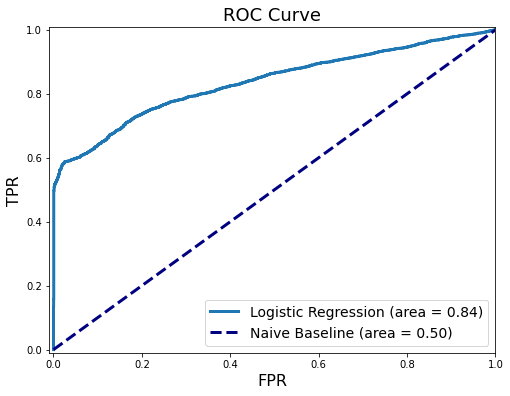

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_log, y_prob_log)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [28]:
train_enc = pd.get_dummies(insurance_train, columns = ['Gender','Vehicle_Age', 'Vehicle_Damage'])
test_enc = pd.get_dummies(insurance_test, columns = ['Gender','Vehicle_Age', 'Vehicle_Damage'])
X_train_class = train_enc.drop(['Does_Not_Buy'], axis=1)

#variable we are predicting
X_train_class = train_enc.drop(columns=['Does_Not_Buy'])
X_test_class = test_enc.drop(columns=['Does_Not_Buy'])
y_train_class = train_enc['Does_Not_Buy']
y_test_class = test_enc['Does_Not_Buy']

In [34]:
#grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               #'class_weight' : ['balanced'],
               #'random_state': [88]}

#dtc = DecisionTreeClassifier()
#dtc_cv = GridSearchCV(dtc, param_grid = grid_values, cv=10, verbose=1,
                              #scoring = 'accuracy')
#dtc_cv.fit(X_train_class, y_train_class)

In [39]:
dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.001,
                             random_state = 88)

dtc = dtc.fit(X_train_class, y_train_class)

Node count = 15


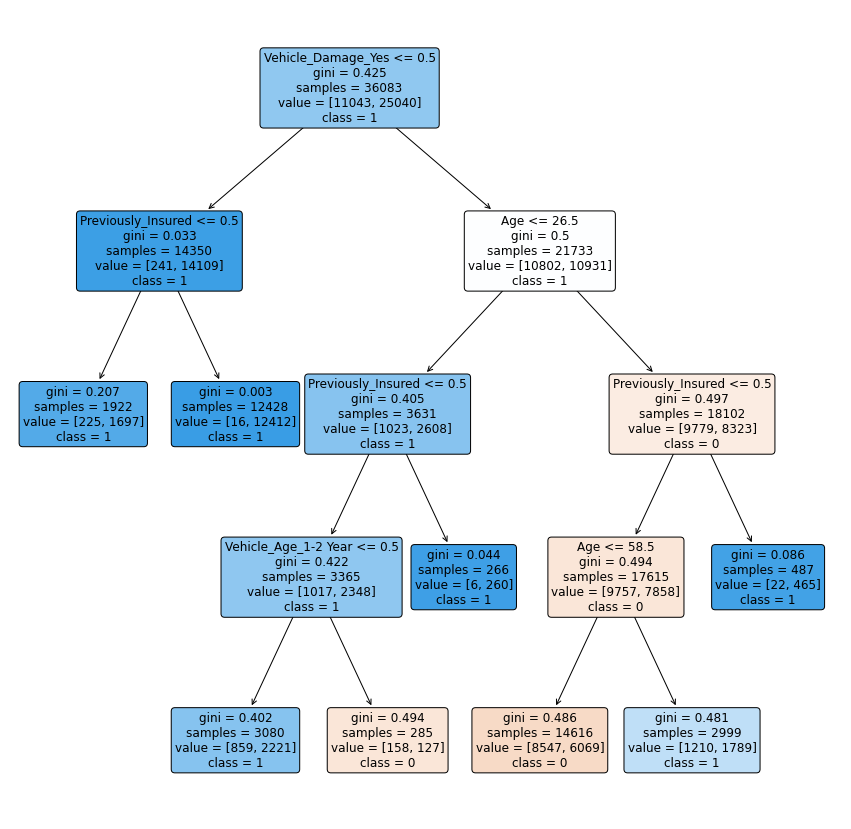

In [42]:
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(15,15))
plot_tree(dtc, 
          feature_names=X_train_class.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

In [53]:
y_pred_dtc = dtc.predict(X_test_class)

cm_dtc = confusion_matrix(y_test_class, y_pred_dtc)

print ("Confusion Matrix : \n", cm_dtc)

acc_dtc = (cm_dtc.ravel()[0]+cm_dtc.ravel()[3])/sum(cm_dtc.ravel())
TPR_dtc = cm_dtc.ravel()[3]/(cm_dtc.ravel()[3]+cm_dtc.ravel()[2])
FPR_dtc = cm_dtc.ravel()[1]/(cm_dtc.ravel()[1]+cm_dtc.ravel()[0])
print('Accuracy is: %.4f' %acc_dtc)
print('TPR is: %.4f' % TPR_dtc)
print('FPR is: %.4f' % FPR_dtc)

Confusion Matrix : 
 [[2893  775]
 [2028 6332]]
Accuracy is: 0.7670
TPR is: 0.7574
FPR is: 0.2113


In [57]:
pd.DataFrame(np.array([['Logistic Regression', acc_log, TPR_log, FPR_log], 
                       ['Decision Tree Classifier', acc_dtc, TPR_dtc, FPR_dtc], 
                       ['Baseline', acc_baseline, TPR_baseline, FPR_baseline]]),
                   columns=['Model', 'Accuracy', 'TPR', 'FPR'])

,Model,Accuracy,TPR,FPR
0,Logistic Regression,0.7334552710342535,0.9139952153110048,0.6780261723009815
1,Decision Tree Classifier,0.7669604256734287,0.7574162679425838,0.21128680479825518
2,Baseline,0.6950448952444297,1.0,1.0


As we can see in the dataframe above, the decision tree classifier model had the highest accuracy and the lowest FPR. The logistic regressoin had a slightly lower accuracy than the decision tree, but a higher TPR (recall). However, the FPR was higher for the logsitic regression as well.  Depending on the company's goals, we can select a model we think is best.

The TPR indicates the proportion of predictions that correctly identified customers who do not want to buy the insurance. The FPR indicates the proportion of predictions that incorrectly identified customers who want to buy the insurance (i.e., they actually want to buy the insurance but the prediction indicated that they did not want to). If customers do not want to buy insurance, the company loses 3000 or 3500 per person depending on whether additional services were paid for or not. To minimize the cost, it is important to select a model that will correctly identify customers who do not want to buy insurance and differentiate them for those who do. 

I think the decision tree classifer is the more appropriate model for the company because the accuracy is the highest. While the TPR is lower than that of the logistic regression model, it is still relatively good, and the FPR is significantly lower than that of the logistic regression model. I think this trade-off is optimal for the company's needs because they can better identify customers who want to purchase the insurance and still do a decent job of predicting customers who don't. This will help influence the company's policy.

I will work on part c below:

In [64]:
def find_p_threshold(alpha):
    p = -500 / (-3000 + (3000 * alpha))
    return p
find_p_threshold(0.5), find_p_threshold(0.55), find_p_threshold(0.6), find_p_threshold(0.65), find_p_threshold(0.7)

(0.3333333333333333,
 0.3703703703703704,
 0.4166666666666667,
 0.47619047619047616,
 0.5555555555555556)

In [65]:
y_pred_0_5 = pd.Series([1 if x > 0.33 else 0 for x in y_prob_log], index=y_prob_log.index)
y_pred_0_55 = pd.Series([1 if x > 0.37 else 0 for x in y_prob_log], index=y_prob_log.index)
y_pred_0_65 = pd.Series([1 if x > 0.476 else 0 for x in y_prob_log], index=y_prob_log.index)
y_pred_0_7 = pd.Series([1 if x > 0.556 else 0 for x in y_prob_log], index=y_prob_log.index)

In [71]:
cm_log_0_5 = confusion_matrix(y_test_log, y_pred_0_5)
acc_log_0_5 = (cm_log_0_5.ravel()[0]+cm_log_0_5.ravel()[3])/sum(cm_log_0_5.ravel()) 
print ("Confusion Matrix : \n", cm_log_0_5) 
print('Accuracy when alpha is 0.5: ', acc_log_0_5)

Confusion Matrix : 
 [[  47 3621]
 [  29 8331]]
Accuracy when alpha is 0.5:  0.6965414033920851


In [75]:
cm_log_0_55 = confusion_matrix(y_test_log, y_pred_0_55)
acc_log_0_55 = (cm_log_0_55.ravel()[0]+cm_log_0_55.ravel()[3])/sum(cm_log_0_55.ravel()) 
print ("Confusion Matrix : \n", cm_log_0_55) 
print('Accuracy when alpha is 0.55: ', acc_log_0_55)

Confusion Matrix : 
 [[ 311 3357]
 [ 166 8194]]
Accuracy when alpha is 0.55:  0.7071000997672099


In [76]:
cm_log_0_65 = confusion_matrix(y_test_log, y_pred_0_65)
acc_log_0_65 = (cm_log_0_65.ravel()[0]+cm_log_0_65.ravel()[3])/sum(cm_log_0_65.ravel()) 
print ("Confusion Matrix : \n", cm_log_0_65) 
print('Accuracy when alpha is 0.65: ', acc_log_0_65)

Confusion Matrix : 
 [[2373 1295]
 [1629 6731]]
Accuracy when alpha is 0.65:  0.7569005653475225


In [77]:
cm_log_0_7 = confusion_matrix(y_test_log, y_pred_0_7)
acc_log_0_7 = (cm_log_0_7.ravel()[0]+cm_log_0_7.ravel()[3])/sum(cm_log_0_7.ravel()) 
print ("Confusion Matrix : \n", cm_log_0_7) 
print('Accuracy when alpha is 0.7: ', acc_log_0_7)

Confusion Matrix : 
 [[2961  707]
 [2241 6119]]
Accuracy when alpha is 0.7:  0.7549052211506485


In [78]:
find_p_threshold(0.67)

0.5050505050505052

In [79]:
y_pred_0_67 = pd.Series([1 if x > 0.505 else 0 for x in y_prob_log], index=y_prob_log.index)

In [80]:
cm_log_0_67 = confusion_matrix(y_test_log, y_pred_0_67)
acc_log_0_67 = (cm_log_0_67.ravel()[0]+cm_log_0_67.ravel()[3])/sum(cm_log_0_67.ravel()) 
print ("Confusion Matrix : \n", cm_log_0_67) 
print('Accuracy when alpha is 0.67: ', acc_log_0_67)

Confusion Matrix : 
 [[2716  952]
 [1911 6449]]
Accuracy when alpha is 0.67:  0.7619720651812437


As we can see, the accuracy of our logistic regression model is highest when our alpha is between 0.65 and 0.7 (0.67 in my analysis), and not 0.6. Thus, a more accurate change in probability of NOT purchase is from p to approximately 0.67p. Our p threshold is closer to 0.505 than 0.417 as previously calculated in part a. This is important because it means that with a p of 0.505, more of our predictions will be classified as 0 instead of 1, which means more people will be predicted to want to buy the insurance. This is useful to the company because it changes their risk analysis and protocols with regards to encouraging people to buy insurance or pursuing additional services. If our model predicts more people want to buy insurance, then the company will be more likely to offer additional services. 